## Initialize

In [1]:
import pandas as pd
import scipy.stats
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## PreProcessing / EDA

In [2]:
ds_movie = pd.read_csv("movie.csv")
ds_rating = pd.read_csv("rating.csv")
df = pd.merge(ds_rating, ds_movie, on='movieId', how='inner')
df = df.sort_values(by=['movieId'])
interactions_count = ds_rating.groupby('userId').size().reset_index(name='num_interactions')
interactions_count.head()
agr_ratings = df.groupby('title').agg(mean_rating = ('rating','mean'), number_of_ratings = ('rating', 'count')).reset_index()
agr_ratings_100 = agr_ratings[agr_ratings['number_of_ratings'] > 10000]
agr_ratings_100.info()
agr_ratings_100.sort_values(by='number_of_ratings', ascending=False).head()
df_100 = pd.merge(df, agr_ratings_100[['title']], on='title', how='inner')

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 38 to 26534
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              462 non-null    object 
 1   mean_rating        462 non-null    float64
 2   number_of_ratings  462 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 14.4+ KB


## Model

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recall_at_k(user_interactions, count, ranked_item_score, ground_truth, k):
    top_k_items = ranked_item_score.head(k)['genres'].tolist()
    actual_items = user_interactions['genres'].tolist()  
    common_items = count
    print(common_items)
    print(len(actual_items))
    recall = common_items / len(actual_items) ## Relevant Items in Top K/Total Relevant Items
    return recall

def model(selectUser):
    temp = interactions_count[interactions_count['userId'] == selectUser]
    ground_truth = temp.iloc[0]['num_interactions']
    matrix_temp = df_100.pivot_table(index='userId', columns='title', values='rating')
    matrix = matrix_temp.iloc[:3000]
    matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
    user_similarity = matrix_norm.T.corr()
    user_similarity.drop(index=selectUser, inplace=True)
    n = 10
    threshold = 0.3
    similar_users = user_similarity[user_similarity[selectUser]>threshold][selectUser].sort_values(ascending=False)[:n]
    picked_userid_watched = matrix_norm[matrix_norm.index == selectUser].dropna(axis=1, how='all')
    similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
    similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
    item_score = {}
    for i in similar_user_movies.columns:
        movie_rating = similar_user_movies[i]
        total = 0
        count = 0
        for u in similar_users.index:
            if pd.isna(movie_rating[u]) == False:
                score = similar_users[u] * movie_rating[u]
                total += score
                count +=1
        item_score[i] = total / count

    item_score = pd.DataFrame(item_score.items(), columns=['title', 'movie_score'])
    ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

    m = 50
    ranked_item_score.head(m)
    ranked_item_score = pd.merge(ranked_item_score, ds_movie[['title', 'genres']], on='title', how='left')
    user_interactions = pd.merge(ds_rating[ds_rating['userId'] == selectUser], ds_movie[['movieId', 'title', 'genres']], on='movieId', how='left')
    user_interactions.drop(columns=['timestamp'])

    k = 50  # Number of top items to consider

    top_n_rits = ranked_item_score.head(k)
    top_n_ui = user_interactions.head(k)

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix_ranked = tfidf_vectorizer.fit_transform(top_n_rits['title'] + ' ' + top_n_rits['genres'])
    tfidf_matrix_user = tfidf_vectorizer.transform(top_n_ui['title'] + ' ' + top_n_ui['genres'])

    similarity_matrix = cosine_similarity(tfidf_matrix_user, tfidf_matrix_ranked)
    similarity_df = pd.DataFrame(similarity_matrix, index=top_n_ui['title'], columns=top_n_rits['title'])
        
    similar_movies = []

    for i, user_movie in enumerate(top_n_ui['title']):
        for j, ranked_movie in enumerate(top_n_rits['title']):
            similarity = similarity_matrix[i, j]
            if similarity > 0.5:
                similar_movies.append((user_movie, ranked_movie))
                
    for user_movie, ranked_movie in similar_movies:
        count += 1
        
    recall = recall_at_k(user_interactions, count, ranked_item_score, temp, k)
    print("User ID : ", selectUser)
    print("Recall@{}: {:.2f}".format(k, recall))
    return recall
    
def reset_variables():
    local_vars = locals().copy()
    for var in local_vars:
        if var != 'reset_variables' and var != 'model':
            del locals()[var]

total = 0          
best = 0
for user in range(1, 10):
    val = model(user)
    if(val > best):
        best = val
    total += val
    print("Total Value : ", total)
    print("--------------------------------------")
    reset_variables()
    
print("Average Performance of Recall@50 : ", total/10)
print("Best Value  : ", best)

24
175
User ID :  1
Recall@50: 0.14
Total Value :  0.13714285714285715
--------------------------------------
23
61
User ID :  2
Recall@50: 0.38
Total Value :  0.514192037470726
--------------------------------------
38
187
User ID :  3
Recall@50: 0.20
Total Value :  0.7174005936204586
--------------------------------------
15
28
User ID :  4
Recall@50: 0.54
Total Value :  1.2531148793347442
--------------------------------------
16
66
User ID :  5
Recall@50: 0.24
Total Value :  1.4955391217589866
--------------------------------------
7
24
User ID :  6
Recall@50: 0.29
Total Value :  1.7872057884256534
--------------------------------------
29
276
User ID :  7
Recall@50: 0.11
Total Value :  1.8922782521937693
--------------------------------------
22
70
User ID :  8
Recall@50: 0.31
Total Value :  2.2065639664794836
--------------------------------------
15
35
User ID :  9
Recall@50: 0.43
Total Value :  2.635135395050912
--------------------------------------
Average Performance of Reca

## Results

### Recall@50
- From 10 Samples : 0.2635135395050912 (best 0.5357142857142857) 
- From 100 Samples : 0.27457576746647855 (best 0.8)
- From 280 Samples (Error on ID 281) 0.27342825934544785
- From 1000 Samples : 
- From 10000 Samples : 
- From 100000 Samples : 

In [4]:
import matplotlib.pyplot as plt

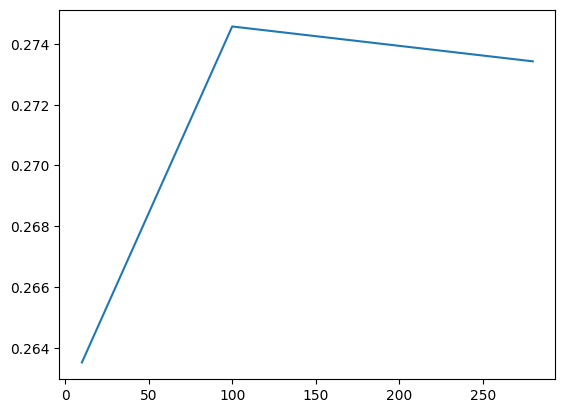

In [5]:
X = [10, 100, 280]
Y = [0.2635135395050912, 0.27457576746647855, 0.27342825934544785]

plt.plot(X,Y)
plt.show()